## Image segmentation

Clustering is commonly used for image segmentation. The goal of image segmentation is to divide the image into similar regions. Usually it's done by finding the most similar colors - grouping colors used in image into clusters. In the example below we implement two classes: ``ImageConversion`` and ``Segmentation``.

Before we go to the implementation part, we need to import several packages. We use the same that are used in the hard k-means example like numpy and math for calculation. The random package is used for intializing random centers and math is used for the Euclidean distance. 


In [1]:
import numpy
import random
import math
import matplotlib.image as img
from PIL import Image

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

The ``ImageConersion`` class has three methods:
- ``get_image_from_url`` - load the image,
- ``get_unique_colours`` - find all unique colors in an image,
- ``save_image`` - save the segmented image.

We get all unique colors because of performance reasons.

In [2]:
class ImageConversion:

    def get_image_from_url(self, img_url):
        image = open(img_url,'rb')
        return img.imread(image)

    def get_unique_colours(self, image_matrix):
        feature_matrix = []
        for i in range(len(image_matrix)):
            for j in range(len(image_matrix[0])):
                feature_matrix.append(image_matrix[i, j])
        feature_matrix_np = numpy.array(feature_matrix)
        uniques, index = numpy.unique([str(i) for i in feature_matrix_np], return_index=True)
        return feature_matrix_np[index], feature_matrix

    def save_image(self, size, pixel_matrix, unique_matrix, assignation_matrix, colours, output):
        image_out = Image.new("RGB", size)
        pixels = []
        for i in range(len(pixel_matrix)):
            pixel_list = pixel_matrix[i].tolist()
            for j in range(len(unique_matrix)):
                if(pixel_list == unique_matrix[j].tolist()):
                    for k in range(len(colours)):
                        if assignation_matrix[j][k] == 1:
                            segmented_colours=[int(i) for i in (colours[k]*255)]
                            pixels.append(tuple(segmented_colours))
        image_out.putdata(pixels)
        image_out.save(output)

The ``Segmentation`` class has the same methods as hard k-means. The assignation matrix is related to the number of unique colors in the image. Centers are set in the RGB color space. 

In [3]:
class Segmentation:

    def __init__(self, feature_matrix, groups):
        self.__data_set = feature_matrix
        self.__groups = groups
        self.__space=[[0, 255], [0, 255], [0, 255]]
        self.__error_margin = 0.5
        self.assignation = numpy.zeros((len(self.__data_set), self.__groups))
        self.centers = []
        self.select_centers()

    def select_centers(self):
        if len(self.centers) == 0:
            iter=0
            while iter<self.__groups:
                self.centers.append(((random.randrange(0, 255)*1.0/255),
                                     (random.randrange(0, 255)*1.0/255),
                                     (random.randrange(0, 255)*1.0/255)))
                iter=iter+1

    def calculate_distance(self, x, v):
        return math.sqrt((x[0]-v[0])**2+(x[1]-v[1])**2+(x[2]-v[2])**2)

    def calculate_u(self, x, i):
        smallest_distance = float(self.calculate_distance(x, self.centers[0]))
        smallest_id = 0
        for i in range(1, self.__groups):
            distance = self.calculate_distance(x, self.centers[i])
            if distance < smallest_distance:
                smallest_id = i
                smallest_distance = distance
        distance = numpy.zeros(self.__groups)
        distance[smallest_id]=1
        return distance

    def calculate_new_centers(self, u):
        new_centers=[]
        for c in range(self.__groups):
            u_x_vector = numpy.zeros(len(self.centers[0]))
            u_scalar = 0
            for i in range(len(u)):
                u_scalar = u_scalar + u[i][c]
                u_x_vector = numpy.add(u_x_vector, numpy.multiply(u[i][c], self.__data_set[i]))
            new_centers.append(numpy.divide(u_x_vector,u_scalar))
        self.centers = new_centers

    def calculate_differences(self,new_assignation):
        diff=0
        for i in range(len(self.assignation)):
            for j in range(self.__groups):
                diff = diff + abs(float(new_assignation[i][j]) - float(self.assignation[i][j]))
        return diff

    def do_segmentation(self):
        difference_limit_not_achieved = True
        iter = 0
        while difference_limit_not_achieved:
            new_assignation = []
            for i in range(len(self.__data_set)):
                new_assignation.append(self.calculate_u(self.__data_set[i], iter))
            self.calculate_new_centers(new_assignation)

            if iter > 0:
                if self.calculate_differences(new_assignation) < self.__error_margin:
                    difference_limit_not_achieved=False
            self.assignation = new_assignation
            iter = iter + 1

    def get_results(self):
        return self.centers, self.assignation

Finally, we can use it with clustering for image segmentation.  In the first place we load the image and get the list of unique colors. Next, we set the number of clusters (``groups``). The segmentation part takes the unique colors, put it into a three-dimensional space and find centers of three clusters. It returns the assignation matrix with a cluster id assgined to each color. The image is saved based on the colors of centers assigned to each colors. Each pixel of a given color is replaced with the colors of the center of assigned cluster. 

In [4]:
image_to_segment = "logo_krakow.png"
image_converter = ImageConversion()
image_data = image_converter.get_image_from_url(image_to_segment)
unique_image_data, image_data_list = image_converter.get_unique_colours(image_data)

groups = 3

segmentation = Segmentation(unique_image_data, groups)
segmentation.do_segmentation()
centers, assignation_matrix = segmentation.get_results()

image_size = (232, 258)
image_converter.save_image(image_size, image_data_list, unique_image_data, assignation_matrix, centers, "segmented.png")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


The centers represents the values in RGB:

In [5]:
centers

[array([0.2741006 , 0.48242116, 0.66588237]),
 array([nan, nan, nan]),
 array([0.83754694, 0.8201641 , 0.6602976 ])]

We can easily draw the three-dimensional feature space with all unique colors drawn as points, and centers as black squares.

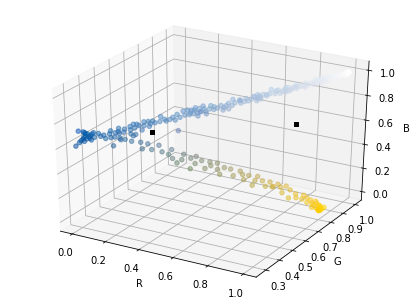

In [6]:
%matplotlib inline

fig = pyplot.figure()
ax = Axes3D(fig)
ax.set_aspect("equal")
x_centers = [item[0] for item in centers]
y_centers = [item[1] for item in centers]
z_centers = [item[2] for item in centers]

x_values = [item[0] for item in unique_image_data]
y_values = [item[1] for item in unique_image_data]
z_values = [item[2] for item in unique_image_data]
ax.scatter(x_values, y_values, z_values, c=numpy.array(unique_image_data),alpha=0.5)

ax.scatter(x_centers, y_centers, z_centers, c='black',marker='s',alpha=1)

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

pyplot.show()

The converted image is given as below. We see that there are only three colors in the image.

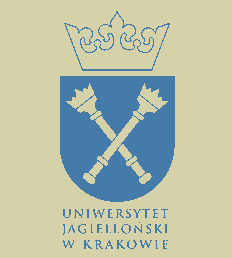

In [7]:
from IPython.display import Image
Image("segmented.png")